In [1]:
import numpy as np
import librosa
from IPython.display import Audio
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:

def gcc_phat(sig, refsig, fs=1, interp=16):
    '''
    This function computes the offset between the signal sig and the reference signal refsig
    using the Generalized Cross Correlation - Phase Transform (GCC-PHAT) method.
    '''
    # make sure the length for the FFT is larger or equal than len(sig) + len(refsig)
    n = sig.shape[0] + refsig.shape[0]

    # Generalized Cross Correlation Phase Transform
    SIG = np.fft.rfft(sig, n=n)
    REFSIG = np.fft.rfft(refsig, n=n)
    R = SIG * np.conj(REFSIG)

    cc = np.fft.irfft(R / (np.abs(R) + 1e-10), n=interp * n)  
    

    max_shift = int(interp * n / 2)
    # print(np.argmax(np.abs(cc)))

    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    # print(np.argmax(np.abs(cc)))
    # # find max cross correlation index
    
    # shift = np.argmax(np.abs(cc)) - max_shift

    # tau = shift / float(interp * fs)
    return  cc#,tau


In [3]:
# (np.argmax(np.abs(cc)) - int(sig_len * 16)) / (16000 * 16)

In [4]:
# np.linspace(-sig_len/ fs, sig_len/ fs, 16 * sig_len * 2 +1).astype(np.float32)[np.argmax(np.abs(cc))]

In [5]:
# np.argmax(np.abs(cc))

In [6]:
# fs = 16000  # Sampling frequency (Hz)
# f = 10  # Frequency of sine wave (Hz)
# seconds = 1  # Duration of the signal (s)
# t = np.arange(0, seconds, 1/fs)

# # Generate Sine Waves
# sig1 = wav[0]#np.concatenate([np.zeros(1000),np.sin(2 * np.pi * f * t)*3, np.zeros(1000)])  # First sine wave
# delay_time = 0.02 # 1/4 second delay
# delay_samples = int(delay_time * fs)  # Convert delay to samples
# print(delay_samples / fs)
# sig2 = np.roll(sig1, delay_samples)  # Second sine wave with delay
# sig_len = sig1.shape[0]

# delay_axs = np.linspace(-sig_len/ fs, sig_len/ fs,16*sig_len * 2 +1).astype(np.float32)

# # Apply GCC-PHAT
# cc = gcc_phat(sig1, sig2, fs)

# delay_axs[np.argmax(np.abs(cc))]
# # (np.argmax(np.abs(cc )) - sig1.shape[0])  / fs
# # # Plot the Cross-Correlation
# # plt.figure(figsize=(10, 5))
# # plt.plot(tau_axis, cc)
# # plt.axvline(x=estimated_delay, color='r', linestyle='--', label=f'Estimated Delay = {estimated_delay:.4f} s')
# # plt.xlabel("Time Shift (s)")
# # plt.ylabel("Cross-Correlation")
# # plt.title("GCC-PHAT Cross-Correlation")
# # plt.legend()
# # plt.grid()
# # plt.show()

# # # Print the Estimated Delay
# # print(f"Estimated Delay: {estimated_delay:.4f} seconds")
# # print(f"Expected Delay: {delay_time} seconds")

In [7]:
import itertools
def srp_phat(signals, mic_positions, grid, fs, interp = 16):
    """Perform SRP-PHAT localization."""
    num_mics = len(mic_positions)
    srp_map = np.zeros(grid.shape[0], dtype=np.float32)

    sig_len = signals.shape[1]

    delay_axs = np.linspace(-sig_len/ fs, sig_len/ fs, interp*sig_len * 2 +1).astype(np.float32) # mapping between index and delay in seconds

    n_channels = signals.shape[0]
    # taus = np.zeros((n_channels, n_channels))
    gccs = {}
    for (i, j) in itertools.combinations(range(num_mics), 2):
        if i == j:
            continue
        cc = gcc_phat(signals[i], signals[j], fs=fs, interp=interp)
        # print(i,j,tau)
        gccs[(i,j)] = cc


    for idx,candidate in enumerate(grid):
        power = 0
        for (i, j) in itertools.combinations(range(num_mics), 2):
            if i == j:
                continue
            dist_i = np.linalg.norm(candidate - mic_positions[i])
            dist_j = np.linalg.norm(candidate - mic_positions[j])
            tau = (dist_i - dist_j) / 343.0  # Speed of sound (m/s)
            
            gcc = gccs[(i,j)]
            
            closest_idx = np.argmin(np.abs(delay_axs - tau))
            power += gcc[closest_idx]

        srp_map[idx] = power

    return srp_map

In [8]:
d = 0.2
fs = 16000

mic_pos = np.array([
          [2.6 - d / 2, 3, 1.5], [2.6 + d / 2, 3, 1.5], [2.6, 3-d/2, 1.5], [2.6 , 3+d/2, 1.5]

      ])
room_dim = [5.2,6.2,3.5]


In [9]:
from scipy.signal import fftconvolve
import rir_generator as rir



def rnd_speaker_pos():
  x = np.random.uniform(low=1, high=4, size=(1,))[0]
  y = np.random.uniform(low=1, high=5, size=(1,))[0]
  speaker_pos =  [x, y, 1.5]
  return speaker_pos

def gen_rir(t60,pos):

  h = rir.generate(
      c=340,                  # Sound velocity (m/s)
      fs=fs,                  # Sample frequency (samples/s)
      r=mic_pos,

      s=pos,          # Source position [x y z] (m)
      L=room_dim,            # Room dimensions [x y z] (m)
      reverberation_time=t60, # Reverberation time (s)
      nsample=int(t60 * fs),           # Number of output samples
  )
      # [1.617, 2.45, 1.7]
  return h

def add_white_noise(signal, snr_db=10):
    if len(signal.shape) == 1 :
      signal = signal.reshape(1,-1)
    signal_power = np.mean(signal**2,axis=1, keepdims=True)
    noise_power = signal_power / (10**(snr_db / 10))
    noise = np.sqrt(noise_power) * np.random.normal(0, 1, signal.shape) # spectral and spatial white noise - uncorollated sensors
    noisy_signal = signal + noise
    return noisy_signal, noise


def convolve_rir(signal, rirs):
     rirs = rirs.T
     return np.stack([np.convolve(signal, rir, mode='full') for rir in rirs])


In [10]:
wav, sr = librosa.load('12.wav', sr=None, mono=False)
speaker_pos = rnd_speaker_pos()
imp03_main = gen_rir(0.3,speaker_pos)

main_speaker_room = convolve_rir(wav, imp03_main)

main_speaker_room_noisy_white, white_noise = add_white_noise(main_speaker_room, snr_db=15)

grid = np.array([[x, y, 1.5] for x in np.linspace(0, room_dim[0], 20) for y in np.linspace(0, room_dim[1], 20)])

srp = srp_phat(main_speaker_room_noisy_white, mic_pos, grid, sr, interp=1)
best_pos = srp.argmax()


srp = srp_phat(main_speaker_room_noisy_white, mic_pos, grid, sr, interp=1)
best_pos = srp.argmax()
print(f"Estimated Source Position: {grid[best_pos]}")
print(f"True Source Position: {speaker_pos}")


srp_map = srp
srp_map = srp_map.reshape(20, 20)
fig = px.imshow(srp_map.T, x=np.linspace(0, room_dim[0], 20), y=np.linspace(0, room_dim[1], 20))
#  add the microphones
fig.add_trace(go.Scatter(x=mic_pos[:, 0], y=mic_pos[:, 1], mode='markers', marker=dict(size=10, color='red')))
# add the estimated source position
fig.add_trace(go.Scatter(x=[grid[best_pos][0]], y=[grid[best_pos][1]], mode='markers', marker=dict(size=10, color='blue')))
fig.add_trace(go.Scatter(x=[speaker_pos[0]], y=[speaker_pos[1]], mode='markers', marker=dict(size=10, color='green')))
fig.update_layout(title='SRP-PHAT Map',
                  xaxis_title='X (m)',
                  yaxis_title='Y (m)')
fig.show()


Estimated Source Position: [0.         0.32631579 1.5       ]
True Source Position: [2.0949225203200483, 2.4983825404623152, 1.5]


In [27]:
dists_from_mics = np.linalg.norm(grid[:, None] - mic_pos, axis=2)
tau = dists_from_mics / 343.0

nfft = 512
hoplength = 256
stft_main_speaker_room_noisy_white = librosa.stft(main_speaker_room_noisy_white, n_fft=nfft, hop_length=hoplength)


stft_sig = stft_main_speaker_room_noisy_white
H = stft_sig.transpose(1,0,2)  @ stft_sig.transpose(1,2,0).conj() / stft_sig.shape[2]
val,vec = np.linalg.eigh(H)
noise_space = vec[:,:,1:]
omega_f =  fs * np.arange(nfft // 2 + 1) / nfft
steering_vec = np.exp(-1j * 2 * np.pi * omega_f * tau[:, :, None])
Pmu = []
for f in range(nfft // 2 + 1):
    Pmu_f = (np.abs(steering_vec[:,:,f].conj() @ noise_space[f])**2).sum(-1)
    Pmu.append(Pmu_f)
Pmu = np.array(Pmu)

spec = Pmu.mean(0)
best_pos = spec.argmax()
print(f"Estimated Source Position: {grid[best_pos]}")
spec_map = spec.reshape(20, 20)
spec_map = spec_map / spec_map.max()

fig = px.imshow(spec_map, x=np.linspace(0, room_dim[0], 20), y=np.linspace(0, room_dim[1], 20))
#  add the microphones
fig.add_trace(go.Scatter(x=mic_pos[:, 0], y=mic_pos[:, 1], mode='markers', marker=dict(size=10, color='red')))
# add the estimated source position
fig.add_trace(go.Scatter(x=[grid[best_pos][0]], y=[grid[best_pos][1]], mode='markers', marker=dict(size=10, color='blue')))
fig.add_trace(go.Scatter(x=[speaker_pos[0]], y=[speaker_pos[1]], mode='markers', marker=dict(size=10, color='green')))
fig.update_layout(title='SRP-PHAT Map',
                  xaxis_title='X (m)',
                  yaxis_title='Y (m)')
fig.show()


Estimated Source Position: [0.54736842 0.97894737 1.5       ]


In [12]:
# print(f"Estimated Source Position: {grid[best_pos]}")
# print(f"True Source Position: {speaker_pos}")

In [13]:
import scipy.linalg as LA
import scipy.signal as ss

def array_response_vector(array,theta):
    N = array.shape
    v = np.exp(1j*2*np.pi*array*np.sin(theta))
    return v

def music(CovMat,L,N,array,Angles):
    # CovMat is the signal covariance matrix, L is the number of sources, N is the number of antennas
    # array holds the positions of antenna elements
    # Angles are the grid of directions in the azimuth angular domain
    _,V = LA.eig(CovMat)
    Qn  = V[:,L:N]
    numAngles = Angles.size
    pspectrum = np.zeros(numAngles)
    for i in range(numAngles):
        av = array_response_vector(array,Angles[i])
        # print(Qn.shape)
        # print(av.shape)
        pspectrum[i] = 1/LA.norm((Qn.conj().transpose()@av))
    print(CovMat.shape)
    psindB    = np.log10(10*pspectrum/pspectrum.min())
    DoAsMUSIC,_= ss.find_peaks(psindB,height=1.35, distance=1.5)
    return DoAsMUSIC,pspectrum

In [14]:
Angles = np.linspace(-np.pi/2,np.pi/2,360)

In [15]:
d,p = music(H[11], 1,4, mic_pos, Angles)

(4, 4)


In [16]:
best_idx = p.argmax()

In [17]:
best_idx

100

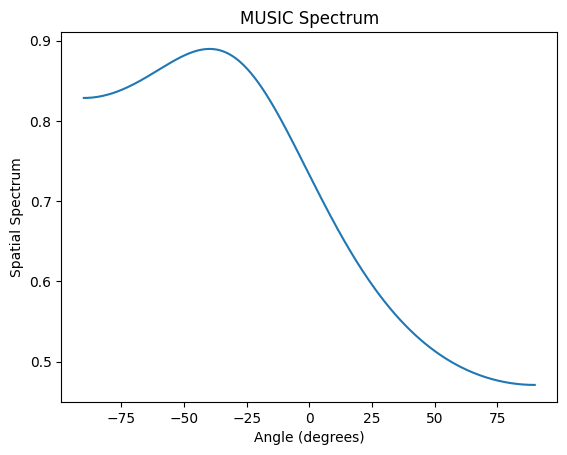

In [18]:
angles_deg = np.degrees(Angles)
plt.plot(angles_deg, p)
plt.plot(angles_deg[d], p[d], "x")
plt.xlabel('Angle (degrees)')
plt.ylabel('Spatial Spectrum')
plt.title('MUSIC Spectrum')
plt.show()


In [19]:
# Author: Eric Bezzam
# Date: July 15, 2016

import numpy as np


from pyroomacoustics.doa import DOA

class MUSIC(DOA):
    """
    Class to apply MUltiple SIgnal Classication (MUSIC) direction-of-arrival
    (DoA) for a particular microphone array.

    .. note:: Run locate_source() to apply the MUSIC algorithm.

    Parameters
    ----------
    L: numpy array
        Microphone array positions. Each column should correspond to the
        cartesian coordinates of a single microphone.
    fs: float
        Sampling frequency.
    nfft: int
        FFT length.
    c: float
        Speed of sound. Default: 343 m/s
    num_src: int
        Number of sources to detect. Default: 1
    mode: str
        'far' or 'near' for far-field or near-field detection
        respectively. Default: 'far'
    r: numpy array
        Candidate distances from the origin. Default: np.ones(1)
    azimuth: numpy array
        Candidate azimuth angles (in radians) with respect to x-axis.
        Default: np.linspace(-180.,180.,30)*np.pi/180
    colatitude: numpy array
        Candidate elevation angles (in radians) with respect to z-axis.
        Default is x-y plane search: np.pi/2*np.ones(1)
    frequency_normalization: bool
        If True, the MUSIC pseudo-spectra are normalized before averaging across the frequency axis, default:False
    """

    def __init__(
        self,
        L,
        fs,
        nfft,
        c=343.0,
        num_src=1,
        mode="far",
        r=None,
        azimuth=None,
        colatitude=None,
        frequency_normalization=False,
        **kwargs
    ):
        DOA.__init__(
            self,
            L=L,
            fs=fs,
            nfft=nfft,
            c=c,
            num_src=num_src,
            mode=mode,
            r=r,
            azimuth=azimuth,
            colatitude=colatitude,
            **kwargs
        )

        self.Pssl = None
        self.frequency_normalization = frequency_normalization

    def _process(self, X):
        """
        Perform MUSIC for given frame in order to estimate steered response
        spectrum.
        """
        # compute steered response
        self.Pssl = np.zeros((self.num_freq, self.grid.n_points))
        C_hat = self._compute_correlation_matricesvec(X)
        # subspace decomposition
        Es, En, ws, wn = self._subspace_decomposition(C_hat[None, ...])
        # compute spatial spectrum
        identity = np.zeros((self.num_freq, self.M, self.M))
        identity[:, list(np.arange(self.M)), list(np.arange(self.M))] = 1
        cross = identity - np.matmul(Es, np.moveaxis(np.conjugate(Es), -1, -2))
        self.Pssl = self._compute_spatial_spectrumvec(cross)
        if self.frequency_normalization:
            self._apply_frequency_normalization()
        self.grid.set_values(np.squeeze(np.sum(self.Pssl, axis=1) / self.num_freq))

    def _apply_frequency_normalization(self):
        """
        Normalize the MUSIC pseudo-spectrum per frequency bin
        """
        self.Pssl = self.Pssl / np.max(self.Pssl, axis=0, keepdims=True)

    def plot_individual_spectrum(self):
        """
        Plot the steered response for each frequency.
        """

        # check if matplotlib imported
        try:
            import matplotlib.pyplot as plt
        except ImportError:
            import warnings

            warnings.warn("Matplotlib is required for plotting")
            return

        # only for 2D
        if self.grid.dim == 3:
            pass
        else:
            import warnings

            warnings.warn("Only for 2D.")
            return

        # plot
        for k in range(self.num_freq):
            freq = float(self.freq_bins[k]) / self.nfft * self.fs
            azimuth = self.grid.azimuth * 180 / np.pi

            plt.plot(azimuth, self.Pssl[k, 0 : len(azimuth)])

            plt.ylabel("Magnitude")
            plt.xlabel("Azimuth [degrees]")
            plt.xlim(min(azimuth), max(azimuth))
            plt.title("Steering Response Spectrum - " + str(freq) + " Hz")
            plt.grid(True)

    def _compute_spatial_spectrumvec(self, cross):
        mod_vec = np.transpose(
            np.array(self.mode_vec[self.freq_bins, :, :]), axes=[2, 0, 1]
        )
        # timeframe, frequ, no idea
        denom = np.matmul(
            np.conjugate(mod_vec[..., None, :]), np.matmul(cross, mod_vec[..., None])
        )
        return 1.0 / abs(denom[..., 0, 0])

    def _compute_spatial_spectrum(self, cross, k):
        P = np.zeros(self.grid.n_points)

        for n in range(self.grid.n_points):
            Dc = np.array(self.mode_vec[k, :, n], ndmin=2).T
            Dc_H = np.conjugate(np.array(self.mode_vec[k, :, n], ndmin=2))
            denom = np.linalg.multi_dot([Dc_H, cross, Dc])
            P[n] = 1 / abs(denom[0, 0])

        return P

    # non-vectorized version
    def _compute_correlation_matrices(self, X):
        C_hat = np.zeros([self.num_freq, self.M, self.M], dtype=complex)
        for i in range(self.num_freq):
            k = self.freq_bins[i]
            for s in range(self.num_snap):
                C_hat[i, :, :] = C_hat[i, :, :] + np.outer(
                    X[:, k, s], np.conjugate(X[:, k, s])
                )
        return C_hat / self.num_snap

    # vectorized version
    def _compute_correlation_matricesvec(self, X):
        # change X such that time frames, frequency microphones is the result
        X = np.transpose(X, axes=[2, 1, 0])
        # select frequency bins
        X = X[..., list(self.freq_bins), :]
        # Compute PSD and average over time frame
        C_hat = np.matmul(X[..., None], np.conjugate(X[..., None, :]))
        # Average over time-frames
        C_hat = np.mean(C_hat, axis=0)
        return C_hat

    # vectorized versino
    def _subspace_decomposition(self, R):
        # eigenvalue decomposition!
        # This method is specialized for Hermitian symmetric matrices,
        # which is the case since R is a covariance matrix
        w, v = np.linalg.eigh(R)

        # This method (numpy.linalg.eigh) returns the eigenvalues (and
        # eigenvectors) in ascending order, so there is no need to sort Signal
        # comprises the leading eigenvalues Noise takes the rest

        Es = v[..., -self.num_src :]
        ws = w[..., -self.num_src :]
        En = v[..., : -self.num_src]
        wn = w[..., : -self.num_src]

        return (Es, En, ws, wn)

In [20]:
import pyroomacoustics

In [21]:
m =  music.MUSIC(mic_pos.T, fs, 512, num_src=1, mode="far", r=None, azimuth=None, colatitude=None, frequency_normalization=False)

AttributeError: 'function' object has no attribute 'MUSIC'

In [209]:
self.colatitude_recon

In [179]:
m.locate_source(stft_sig)

AttributeError: 'MUSIC' object has no attribute 'locate_source'

In [166]:
m.M

4

In [38]:
stft_sig.shape

(4, 257, 150)

In [173]:
C_hat = m._compute_correlation_matricesvec(stft_sig)

TypeError: 'NoneType' object is not iterable

In [39]:
from pyroomacoustics.doa import music, srp

In [40]:
pm = music.MUSIC(mic_pos.T, fs, 512, num_src=1, mode="far", r=None, azimuth=None, colatitude=None, frequency_normalization=False)

In [ ]:
pm._compute_correlation_matrices(stft_sig).shape

(112, 4, 4)

In [ ]:
pm.mode_vec.mode_vec

In [42]:
stft_sig.shape

(4, 257, 150)

In [43]:
pm.locate_sources(stft_sig)

In [225]:
pm.colatitude_recon

In [192]:
self = pm
C_hat = pm._compute_correlation_matricesvec(stft_sig)
Es, En, ws, wn = m._subspace_decomposition(C_hat[None, ...])

# self.num_freq = 257

In [193]:
identity = np.zeros((self.num_freq, self.M, self.M))
identity[:, list(np.arange(self.M)), list(np.arange(self.M))] = 1
cross = identity - np.matmul(Es, np.moveaxis(np.conjugate(Es), -1, -2))
self.Pssl = self._compute_spatial_spectrumvec(cross)
if self.frequency_normalization:
    self._apply_frequency_normalization()
self.grid.set_values(np.squeeze(np.sum(self.Pssl, axis=1) / self.num_freq))

In [199]:
self.Pssl.shape

(360, 112)

In [203]:
np.squeeze(np.sum(self.Pssl, axis=1) / self.num_freq).shape

(360,)

In [197]:
cross.shape

(1, 112, 4, 4)

In [136]:
self.M

3

In [195]:
self.num_freq

112